<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Tutorial on generating an explanation for an image-based model on Watson OpenScale

This notebook includes steps for creating an image-based watson-machine-learning model, creating a subscription, configuring explainability, and finally generating an explanation for a transaction.

### Contents
- [1. Setup](#setup)
- [2. Creating and deploying an image-based model](#deployment)
- [3. Subscriptions](#subscription)
- [4. Explainability](#explainability)

**Note**: This notebook is using runtime `IBM Runtime 23.1 on Python 3.10` if you are using IBM Watson Studio or `Python 3.10.x` if using any other tool"

<a id="setup"></a>
## 1. Setup

### 1.1 Install Watson OpenScale and WML packages

In [ ]:
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1

In [ ]:
!pip install --upgrade ibm-watson-machine-learning --no-cache | tail -n 1

Note: Restart the kernel to assure the new libraries are being used.

### 1.2 Configure credentials

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [1]:
CLOUD_API_KEY = "***"
IAM_URL="https://iam.ng.bluemix.net/oidc/token"

In [2]:
WML_CREDENTIALS = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey": CLOUD_API_KEY
}

<a id="deployment"></a>
## 2. Creating and deploying an image-based model

The dataset used is MNIST dataset of handwritten digits. It consists of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More information about the dataset can be found here: https://keras.io/datasets/#mnist-database-of-handwritten-digits

Note: Keras and TensorFlow versions supported by WML are: Keras 2.1.6 with TensorFlow 1.13 backend and Keras 2.2.4 with TensorFlow 1.14 backend. The latter combination is used in this notebook.

### 2.1 Creating a model

In [ ]:
# note: Install these package if you are not running this notebook in IBM Watson Studio
# !pip install keras==2.2.5
# !pip install tensorflow==2.12.0

In [ ]:
!pip install keras_sequential_ascii

In [5]:
#import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras_sequential_ascii import sequential_model_to_ascii_printout
from tensorflow.keras import backend as keras_backend
#print(tensorflow.__version__)

In [6]:
batch_size = 128
num_classes = 10
epochs = 5

In [ ]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras_backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [8]:
# convert class vectors to binary class matrices
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
# Define Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy
def base_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    return model

In [ ]:
cnn_n = base_model()
cnn_n.summary()

In [ ]:
# Vizualizing model structure
sequential_model_to_ascii_printout(cnn_n)

In [ ]:
# Fit model
print(y_train.shape)
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

In [15]:
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
print(scores)
print("Accuracy: %.2f%%" % (scores[1]*100))

[1.8136699199676514, 0.7049000263214111]
Accuracy: 70.49%


In [ ]:
cnn_n.save("mnist_cnn.h5")
!rm mnist_cnn.tar*
!tar -czvf mnist_cnn.tar.gz mnist_cnn.h5

### 2.2 Storing the model

In [ ]:
import json
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(WML_CREDENTIALS)
wml_client.version

In [ ]:
wml_client.spaces.list(limit=10)

In [ ]:
WML_SPACE_ID='e943cd4d-7255-4810-945d-93d3937ba547' # use space id here
wml_client.set.default_space(WML_SPACE_ID)

In [20]:
MODEL_NAME = "MNIST Model"

In [ ]:
software_spec_uid = wml_client.software_specifications.get_uid_by_name("tensorflow_rt23.1-py3.10")
print("Software Specification ID: {}".format(software_spec_uid))
model_props = {
        wml_client.repository.ModelMetaNames.NAME:"{}".format(MODEL_NAME),
        wml_client.repository.ModelMetaNames.TYPE: 'tensorflow_2.12',
        wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    }

In [ ]:
print("Storing model ...")
published_model_details = wml_client.repository.store_model(
    model='mnist_cnn.tar.gz', 
    meta_props=model_props, 
)

model_uid = wml_client.repository.get_model_id(published_model_details)
print("Done")
print("Model ID: {}".format(model_uid))

### 2.3 Deploying the model

In [ ]:
deployment_details = wml_client.deployments.create(
    model_uid, 
    meta_props={
        wml_client.deployments.ConfigurationMetaNames.NAME: "{}".format(MODEL_NAME + " deployment"),
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
)
scoring_url = wml_client.deployments.get_scoring_href(deployment_details)
deployment_uid=wml_client.deployments.get_id(deployment_details)

print("Scoring URL:" + scoring_url)
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

## 3. Subscriptions <a id="subscriptions"></a>

### 3.1 Configuring OpenScale

In [ ]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *


authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY)
wos_client = APIClient(authenticator=authenticator)
wos_client.version

In [26]:
#DB_CREDENTIALS= {"hostname":"","username":"","password":"","database":"","port":"","ssl":True,"sslmode":"","certificate_base64":""}
DB_CREDENTIALS = None
KEEP_MY_INTERNAL_POSTGRES = True

In [ ]:
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DB_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.POSTGRESQL,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DB_CREDENTIALS['hostname'],
                        username=DB_CREDENTIALS['username'],
                        password=DB_CREDENTIALS['password'],
                        db=DB_CREDENTIALS['database'],
                        port=DB_CREDENTIALS['port'],
                        ssl=True,
                        sslmode=DB_CREDENTIALS['sslmode'],
                        certificate_base64=DB_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))

In [31]:
SERVICE_PROVIDER_NAME = "Image Multiclass"
SERVICE_PROVIDER_DESCRIPTION = "Added by tutorial WOS notebook2."

In [32]:
service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for WML instance: {}".format(service_provider_id))

In [ ]:
added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.WATSON_MACHINE_LEARNING,
        deployment_space_id = WML_SPACE_ID,
        operational_space_id = "production",
        credentials=WMLCredentialsCloud(
            apikey=CLOUD_API_KEY,      ## use `apikey=IAM_TOKEN` if using IAM_TOKEN to initiate client
            url=WML_CREDENTIALS["url"],
            instance_id=None
        ),
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id

In [ ]:
asset_deployment_details = wos_client.service_providers.list_assets(data_mart_id=data_mart_id, service_provider_id=service_provider_id, deployment_id = deployment_uid, deployment_space_id = WML_SPACE_ID).result['resources'][0]
asset_deployment_details

In [ ]:
model_asset_details_from_deployment=wos_client.service_providers.get_deployment_asset(data_mart_id=data_mart_id,service_provider_id=service_provider_id,deployment_id=deployment_uid,deployment_space_id=WML_SPACE_ID)
model_asset_details_from_deployment

### 3.2 Subscribe the asset

In [36]:
subscriptions = wos_client.subscriptions.list().result.subscriptions
for subscription in subscriptions:
    sub_model_id = subscription.entity.asset.asset_id
    if sub_model_id == model_uid:
        wos_client.subscriptions.delete(subscription.metadata.id)
        print('Deleted existing subscription for model', model_uid)

In [37]:
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import ScoringEndpointRequest

In [ ]:
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=Asset(
            asset_id=model_asset_details_from_deployment["entity"]["asset"]["asset_id"],
            name=model_asset_details_from_deployment["entity"]["asset"]["name"],
            url=model_asset_details_from_deployment["entity"]["asset"]["url"],
            asset_type=AssetTypes.MODEL,
            input_data_type=InputDataType.UNSTRUCTURED_IMAGE,
            problem_type=ProblemType.MULTICLASS_CLASSIFICATION
        ),
        deployment=AssetDeploymentRequest(
            deployment_id=asset_deployment_details['metadata']['guid'],
            name=asset_deployment_details['entity']['name'],
            deployment_type= DeploymentTypes.ONLINE,
            scoring_endpoint=ScoringEndpointRequest(url=scoring_url) # scoring model without shadow deployment
        ),
        asset_properties=AssetPropertiesRequest(
            probability_fields=['probability']
            )
    ).result
subscription_id = subscription_details.metadata.id
subscription_id

In [ ]:
import time

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

### 3.3 Score the model and get transaction-id

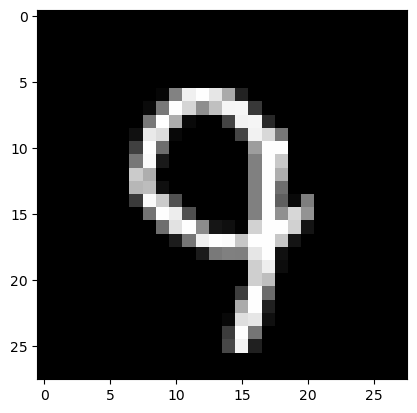

In [41]:
!pip install numpy
!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
img = np.array(x_test[999], dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [42]:
scoring_data = {"input_data": [{"values": [x_test[999].tolist()]}]}
predictions = wml_client.deployments.score(deployment_uid, scoring_data)

Please note that the scoring response stored in the predictions variable, should contain the fields `prediction, prediction_classes(index of the predicted class) and probability` and their corresponding values.

In [43]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "dense_1",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            0.08351116627454758,
            0.0708337128162384,
            0.10256966203451157,
            0.10903555899858475,
            0.11152926832437515,
            0.07864179462194443,
            0.0917503759264946,
            0.10757662355899811,
            0.1082470640540123,
            0.13630476593971252
          ],
          9,
          [
            0.08351116627454758,
            0.0708337128162384,
            0.10256966203451157,
            0.10903555899858475,
            0.11152926832437515,
            0.07864179462194443,
            0.0917503759264946,
            0.10757662355899811,
            0.1082470640540123,
            0.13630476593971252
          ]
        ]
      ]
    }
  ]
}


In [ ]:
wos_client.data_sets.show_records(payload_data_set_id)

<a id="explainability"></a>
## 4. Explainability

### 4.1 Configure Explainability

In [ ]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result

explainability_monitor_id = explainability_details.metadata.id

### 4.2 Get explanation for the transaction

In [ ]:
pl_records_resp = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id, limit=1, offset=0).result
scoring_ids = [pl_records_resp["records"][0]["entity"]["values"]["scoring_id"]]
print("Running explanations on scoring IDs: {}".format(scoring_ids))
explanation_types = ["lime"]
result = wos_client.monitor_instances.explanation_tasks(scoring_ids=scoring_ids, explanation_types=explanation_types, subscription_id=subscription_id).result
print(result)

In [ ]:
explanation_task_id=result.to_dict()['metadata']['explanation_task_ids'][0]
explanation=wos_client.monitor_instances.get_explanation_tasks(explanation_task_id=explanation_task_id, subscription_id=subscription_id).result.to_dict()
explanation

### The explanation images can be obtained using the cells below

In [49]:
!pip install Pillow
from PIL import Image
import base64
import io

time.sleep(10)

img = explanation["entity"]['explanations'][0]['predictions'][0]["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
Image.open(io.BytesIO(img_data))

In [64]:
img = explanation["entity"]['explanations'][0]['predictions'][1]["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
Image.open(io.BytesIO(img_data))

<a id="Quality"></a>
## 5. Quality

### 5.1 Configure Quality

In [ ]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 10
}
quality_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters
).result

quality_monitor_id = quality_details.metadata.id

### 5.2 Store feedback record

In [ ]:
feedback_dataset_id = None
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result
print(feedback_dataset)
feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")

In [ ]:
feedback = []
for i in range(10):
    element = {"scoring_input":x_test[i].tolist(), "target":list(y_test[i]).index(1)}
    feedback.append(element)
wos_client.data_sets.store_records(feedback_dataset_id, request_body=feedback, background_mode=False)

### 5.3 Run Quality monitor

In [ ]:
run_details = wos_client.monitor_instances.run(monitor_instance_id=quality_monitor_id, background_mode=False).result

In [ ]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=quality_monitor_id)